# Generate a list of intersecting areas for input spatial data

Input:
1. Spatial data (points, polygons, etc.)
2. Spatial data to check for overlap, e.g. conservation areas, habitat zones

Output: Input spatial data with added information about overlap

Principle:
User has spatial data that needs to be checked for e.g. conservation area overlap. User can put all input conservation area (or such) datasets
to a single folder, that is iterated layer by layer for a new "Areas" column that lists the name of the layers that intersect input data.
Additional variables can be inspected in similar manner, e.g. if the areas-datasets have a variable named "name", the folder can be iterated
to create a new column "names" that lists all the names mentioned in the overlapping conservation area.



In [1]:
#import necessary modules
import pandas as pd
import geopandas as gpd
import fiona
import os
from datetime import date
import numpy as  np
from shapely import wkt
import dask_geopandas as dask_gpd
import pyogrio


# Excel to spatial data

read your input data from a table to spatial format

In [4]:
point = r"path\pisteet_putkilot_ja_Sammalet.xlsx"
df = pd.read_excel(point)
print(len(df))
df['geometry'] = df['ETRS_TM35FIN_WKT'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf = gdf.set_crs(epsg=3067)
gdf.to_parquet(r"path\point.parquet")
#gdf.to_file(r"path\point.gpkg", driver='GPKG')

87526


<AxesSubplot: >

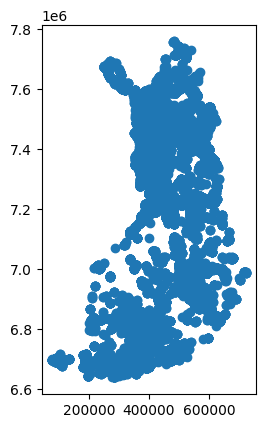

In [ ]:
gdf.plot()

# geopackage layers to geopackages

The method works faster and less error prone on datasets with only one layer, 
so here layers are saved as own datafiles. If all your datasets already include only one layer,
this can be skipped

The output folder is used as the input folder later to check overlap between each layer

In [4]:
source_folder = r"path\ConservationAreas"
destination_folder = r"path\ConservationAreas2"

def save_layers_as_geopackages(source_folder, destination_folder):
    # Iterate through all files in the source folder
    for filename in os.listdir(source_folder):
        if filename.endswith(".gpkg"): #change this if other than gpkg
            # Load the geopackage
            gpkg_path = os.path.join(source_folder, filename)
            
            # Get the list of layers in the geopackage using fiona
            layers = fiona.listlayers(gpkg_path)
            
            # Save each layer as a separate geopackage in the destination folder
            for layer in layers:
                layer_gdf = gpd.read_file(gpkg_path, layer=layer)
                output_path = os.path.join(destination_folder, f"{layer}.gpkg")
                layer_gdf.to_file(output_path, driver="GPKG")
                print(layer, len(layer_gdf))


save_layers_as_geopackages(source_folder, destination_folder)


yksityiset_suojelualueet 16169
valtion_maiden_suojelualueet 1090
eramaaalueet 12
luonnonsuojeluohjelmaalueet 2362
metshallituksen_kiinteistt_kaikki 45979
metshallituksen_kiinteistt_luonnonsuojelutarkoituksiin 21546
natura_viivamaiset_kohteet_toteuttamistapa 15
natura_aluemaiset_kohteet_toteuttamistapa 2270
natura_2000__sac_mannersuomi_aluemaiset 1642
natura_2000__spa_mannersuomi 458
natura_2000__sci__mannersuomi 3
natura_2000__sci_ahvenanmaa_aluemaiset 74
natura_2000__spa_ahvenanmaa 12
soidensuojelun_tydennysehdotuksen_kohteet 747
toteutuneet_valtionmaan_kohteet__luonnonsuojelulailla_suojellut_ 407
toteutuneet_valtionmaan_kohteet_metshallituksen_pysyvll_ptksell_suojellut 565
valtion_muut_suojelualueet 3502


# Conservation area overlap

In [9]:
speciespath = r"path\point.parquet"
folder_path = r'path\ConservationAreas2'
species = gpd.read_parquet(speciespath)
species.sindex #spatial index to possibly speed up processes
print(len(species))

# List of column names to read. They are used to create new columns with desired names
# alter ReadColumnNames to change which columns are handled when iterating through the folder and change WriteColumnNames accordingly
# if there is already a "layer" column, the join is appending _right to it, use it instead if so
WriteColumnNames = ['Areas','Names', 'Names2','Codes']
if 'layer' in gdf.columns:
    ReadColumnNames = ['layer_right','nimi', 'nimisuomi','suojeluperustetunnus']
else:
    ReadColumnNames = ['layer','nimi', 'nimisuomi','suojeluperustetunnus']

# Creating the new columns
for column in WriteColumnNames:
    species[column] = ''

for filename in os.listdir(folder_path):
    if filename.endswith(".gpkg"):
        try:
            file_path = os.path.join(folder_path, filename)
            ddf = dask_gpd.read_file(file_path, npartitions=2)
            gdf = ddf.compute()
        except:
            gdf = gpd.read_file(filename)
        print(filename, len(gdf))
        
        # Add the layer name to the GeoDataFrame
        # Extract the layer name without the file extension
        layer_name = os.path.splitext(filename)[0]
        gdf['layer'] = layer_name


        # Perform spatial join
        areas_on_species = gpd.sjoin(species, gdf, how='left')
        #print(len(areas_on_species),len(species))
        if len(areas_on_species) != len(species):
            for i in range(len(WriteColumnNames)):
                # Filter rows where 'layer' is not null
                # if there is already a "layer" column, the join is appending _right to it, use it instead if so
                try:
                    filtered_df = areas_on_species[areas_on_species['layer'].notnull()]
                except:
                    filtered_df = areas_on_species[areas_on_species['layer_right'].notnull()]
                try:
                    # Create a dictionary to map 'fid' to 'layer'
                    layer_map = dict(zip(filtered_df['fid'], filtered_df[ReadColumnNames[i]]))

                    # Update the column in 'species' DataFrame where 'fid' is in 'layer_map'
                    #if fid in layer_map, add readcolumnname to existing values separated with a comma, else write existing value
                    species[WriteColumnNames[i]] = species.apply(lambda row: row[WriteColumnNames[i]] + layer_map[row['fid']] + ', ' if row['fid'] in layer_map else row[WriteColumnNames[i]],axis=1)
                except:
                    print(f"no column {ReadColumnNames[i]}")
        else:
            print(f"No overlap with {layer_name}")

# Remove trailing commas from the new columns
for column in WriteColumnNames:
    species[column] = species[column].str.rstrip(', ')

# save
species.to_parquet(r"path\pointWareas.parquet")
len(species)


12674
eramaaalueet.gpkg 12
No overlap with eramaaalueet
luonnonsuojeluohjelmaalueet.gpkg 2362
no column nimisuomi
no column suojeluperustetunnus
metshallituksen_kiinteistt_kaikki.gpkg 45979
no column nimi
no column nimisuomi
no column suojeluperustetunnus
metshallituksen_kiinteistt_luonnonsuojelutarkoituksiin.gpkg 21546
no column nimi
no column nimisuomi
no column suojeluperustetunnus
natura_2000__sac_mannersuomi_aluemaiset.gpkg 1642
no column nimi
natura_2000__sci_ahvenanmaa_aluemaiset.gpkg 74
no column nimi
natura_2000__sci__mannersuomi.gpkg 3
No overlap with natura_2000__sci__mannersuomi
natura_2000__spa_ahvenanmaa.gpkg 12
No overlap with natura_2000__spa_ahvenanmaa
natura_2000__spa_mannersuomi.gpkg 458
No overlap with natura_2000__spa_mannersuomi
natura_aluemaiset_kohteet_toteuttamistapa.gpkg 2270
no column nimisuomi
no column suojeluperustetunnus
natura_viivamaiset_kohteet_toteuttamistapa.gpkg 15
No overlap with natura_viivamaiset_kohteet_toteuttamistapa
soidensuojelun_tydennysehd

12674

# Zone overlap

same as before but for a different folder with different areas/zones

In [19]:
speciespath = (r"path\pointWareas.parquet")
species = gpd.read_parquet(speciespath)
species['Zones'] = ''

def list_geopackages_and_layers(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Filter out GeoPackage files
    geopackages = [f for f in files if f.endswith('.gpkg')]
    
    # Dictionary to store layers of each GeoPackage
    geopackage_layers = {}
    
    for gpkg in geopackages:
        gpkg_path = os.path.join(folder_path, gpkg)
        try:
            layers = pyogrio.list_layers(gpkg_path)
            geopackage_layers[gpkg] = layers
        except Exception as e:
            print(f"Error reading {gpkg}: {e}")
    
    return geopackage_layers

# Example usage
folder_path = r'path\Zones'
geopackage_layers = list_geopackages_and_layers(folder_path)

for gpkg, layers in geopackage_layers.items():
    print(f"GeoPackage: {gpkg}")
    for layer in layers:
        print(f"  Layer: {layer}")
        # Read the layer using GeoPandas
        filename = os.path.join(folder_path, gpkg)
        try:
            ddf = dask_gpd.read_file(filename, npartitions=2)
            gdf = ddf.compute()
        except:
            gdf = gpd.read_file(filename, layer=layer[0])
        print(f"    Number of features: {len(gdf)}")
        
        # Add the layer name to the GeoDataFrame
        gdf['layer'] = layer[0]
        
        # Perform spatial join
        areas_on_species = gpd.sjoin(species, gdf, how='left')
        #print(len(species),len(areas_on_species))

        # Filter rows where 'layer' is not null
        filtered_df = areas_on_species[areas_on_species['layer'].notnull()]
        #filtered_df = areas_on_species[areas_on_species['layer_right'].notnull()] # if 'layer' keyerror, uncomment

        # Create a dictionary to map 'fid' to 'nimi'
        layer_map = dict(zip(filtered_df['fid'], filtered_df['nimi']))

        # Update 'Areas' column in 'species' DataFrame where 'fid' is in 'intersections'
        species['Zones'] = species.apply(lambda row: row['Zones'] + layer_map[row['fid']] + ', ' if row['fid'] in layer_map else row['Zones'], axis=1)


species['Zones'] = species['Zones'].str.rstrip(', ')
#species['Area_m2'] = species.geometry.area #for polygons

#species.to_parquet(r"path\polyWareas2.parquet")
species.to_file(r"path\polyWareas2.gpkg")
len(species)

GeoPackage: EUnLuonnonmaantieteellinenAluejako.gpkg
  Layer: ['eun_luonnonmaantieteellinen_alu' 'MultiPolygon']
    Number of features: 884


12674